In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import bamboolib

# 0. Theoretical background

$$r_t^{eqy} = E[r_t^{eqy}] + \beta_1^{eqy} INFL_t+\beta_2^{eqy} GR_t+ \beta_3^{eqy} FS_t + \alpha_t^{eqy}$$
$$r_t^{ust} = E[r_t^{ust}] + \beta_1^{ust} INFL_t+\beta_2^{ust} GR_t+ \beta_3^{ust} FS_t + \alpha_t^{ust}$$
$$\vdots$$
$$r_t^{fxcs} = E[r_t^{fxcs}] + \beta_1^{fxcs} INFL_t+\beta_2^{fxcs} GR_t+ \beta_3^{fxcs} FS_t + \alpha_t^{fxcs}$$

, where
- $INFL_t$ stands for an *inflation* macro-factor return at time t. Likewise, $GR$ for *growth* and $FS$ for *finantial stress* factors.
- $r_t^{eqy}$ is an *excess* return of global equity markets at time t as one of the base assets. T-Bill 1M is used for the excess return calculation. A risk free return such as $r_f$ is omiited for simplicity.
  - $ust$ stands for U.S 10Yr Treasury, and the rest of notation should be the same as that of $eqy$. The same naming rule applies for the rest of base assets in denoting $r_t^{asset}$.
  - A full list of base assets used in this model : Equities($eqy$), Treasuries($ust$), Credit($cre$), Inflation-Linked Bonds($ilb$), Gold(gold), Industrial Metals($inm$), Energy commodity($eng$), U.S. Dollar($dxy$), Commodity vs safe haven currencies ($fxcs$). Abbreviations in ().
- $E[\cdot]$ is an expected excess return.
- $\beta_{\#}^{instrument}$ is a factor beta, or factor loading, for that $instrument$. This value is the **same across all periods** of time being modeled. Therefore, there is no subscript $t$. Instead, we have a digit subscript 1 for $INFL$ beta, 2 for $GR$ beta and 3 for $FS$ beta.
  - e.g. $\beta_1^{eqy}$ is a sensitivy of Equities to $INFL$ factor.
- $E[\alpha^{asset}] = 0$ for all periods of time being modeled.

# 1. Load datasets

#### Set data frequency

In [2]:
_freq = 'W'

## 1) Bloomberg (bbg)
- For data of more recent years.

In [3]:
if _freq == 'M':
    bbg_filename = '../../data/raw/bbg_M.log'
elif _freq == 'W':
    bbg_filename = '../../data/raw/bbg_W.log'

df_bbg = pd.read_csv(bbg_filename, header=2, parse_dates=['date'])
df_bbg = df_bbg.set_index(['date'], drop=True)

In [4]:
df_bbg.tail()

,DMEQ_idx,EMEQ_idx,ACEQ_idx,TBILL3M_yld,UST_idx,CRE_Baa_idx,CRE_Aaa_idx,TIPS_idx,GOLD_pr,NAREIT_idx,...,SPX_idx,FF_rate,UST10YR_yld,DMEQ_etf,UST_etf,TIPS_etf,DXY_etf,GOLD_etf,WTI_etf,NAREIT_etf
date,,,,,,,,,,,,,,,,,,,,,
2020-10-23,7219.40,548.03,294.84,0.0862,124.9686,4466.270,2373.847,345.5637,1902.05,17101.08,...,3465.39,0.09,0.8429,102.3400,120.38,125.85,25.04,178.64,27.88,45.01
2020-10-30,6811.78,532.17,279.22,0.0864,124.7953,4454.748,2372.370,344.4347,1878.81,16186.35,...,3269.96,0.09,0.8737,96.5300,120.06,125.23,25.37,176.20,25.25,42.62
2020-11-06,7339.43,567.41,300.45,0.0862,125.1940,4523.526,2380.886,344.2269,1951.35,16844.32,...,3509.44,0.09,0.8185,103.9200,120.50,125.01,24.89,183.19,26.47,44.32
2020-11-13,7518.61,573.23,307.23,0.0837,124.7005,4524.835,2376.822,345.1101,1889.20,18288.93,...,3585.15,0.09,0.8963,106.6800,119.98,125.33,25.03,177.16,28.13,48.11
2020-11-20,7552.23,583.35,309.12,0.0634,125.1637,4579.240,2387.556,346.3642,1870.99,18175.65,...,3557.54,0.09,0.8243,107.0602,120.50,125.82,24.93,175.69,29.27,47.91


In [5]:
bbg_daily_filename = '../../data/raw/bbg_D.log'
df_bbg_d = pd.read_csv(bbg_daily_filename,
                       header=2,
                       index_col='date',
                       parse_dates=['date'])

Some data are only downloadable at either monthly or daily frequency using BDH in Excel, not weekly. So we do:
- If `_freq` is 'W', feed `CLI_USA` and others in `df_bbg_d` into df_bbg with a proper frequency conversion.

In [6]:
if _freq == 'W':
    df_d2w = df_bbg_d[df_bbg_d.columns.difference(['FF_rate', 'UST10YR_yld'])]
    df_d2w = df_d2w.set_index(df_d2w.index.to_period('D'))
    df_d2w = df_d2w.resample('W-FRI', kind='period').last()
    df_d2w = df_d2w.set_index(df_d2w.index.to_timestamp(how='E').strftime('%Y-%m-%d'))
    df_bbg.drop(df_bbg_d.columns.difference(['FF_rate', 'UST10YR_yld']), axis=1, inplace=True)
    df_bbg = df_bbg.merge(df_d2w, how='left', left_index=True, right_index=True)

## 2) Global Financial Data (gfd)
- For data of older years; since 1850.

In [7]:
if _freq == 'M':
    gfd_filename = '../../data/raw/gfd_M.log'
elif _freq == 'W':
    gfd_filename = '../../data/raw/gfd_W.log'

df_gfd = pd.read_csv(gfd_filename, header=0, parse_dates=['Date'])
df_gfd = df_gfd.rename(columns={'CHFUSD': 'CHFUSD_rate', 'GBPUSD':'GBPUSD_rate'})

In [8]:
df_gfd.columns

Index(['Date', 'Ticker', 'Close'], dtype='object')

In [9]:
df_gfd.shape

(112015, 3)

We pivot this table.

In [10]:
df_gfd = pd.pivot_table(df_gfd, index=['Date'], columns=['Ticker'])

# Drop one of the top multi-index column, namely, "Close"
df_gfd.columns = df_gfd.columns.droplevel(0)

Add a prefix `_rate` to each FX rate column name.

In [11]:
df_gfd.columns = [col + "_rate" if col.find("USD") >= 0 else col for col in df_gfd.columns]

In [12]:
df_gfd.shape

(5766, 26)

In [13]:
df_gfd

,AUDUSD_rate,CPUSAM,GBPUSD_rate,IGUSA10D,ITUSA3CMD,ITUSAA3W,NBM13009USM156N,NBM16078USM509S,TRUSABID,TRUSACOM,...,USDITL_rate,USDJPY_rate,USDNLG_rate,USDNOK_rate,USDSEK_rate,_DJCBPD,_SPXD,_TNXD,__WTC_D,__XAU_D
Date,,,,,,,,,,,,,,,,,,,,,
1910-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235.608529,NaN,...,5.2030,NaN,2.4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1910-01-08,11.908248,NaN,23.816496,NaN,NaN,NaN,NaN,NaN,235.811938,NaN,...,5.1990,NaN,2.4870,3.7212,3.7212,NaN,NaN,NaN,1.40,NaN
1910-01-15,11.884447,NaN,23.768893,NaN,NaN,NaN,NaN,NaN,236.015522,NaN,...,5.2000,NaN,2.4890,3.7250,3.7250,NaN,NaN,NaN,1.40,NaN
1910-01-22,11.884447,NaN,23.768893,NaN,NaN,NaN,NaN,NaN,236.219282,NaN,...,5.2060,NaN,2.4940,3.7250,3.7250,NaN,NaN,NaN,1.40,NaN
1910-01-29,11.884447,NaN,23.768893,NaN,NaN,NaN,NaN,NaN,236.423218,NaN,...,5.2100,NaN,2.4960,3.7250,3.7250,NaN,NaN,NaN,1.40,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-30,0.443276,256.394,1.524198,0.65,0.14,NaN,NaN,NaN,11246.701560,25518.426461,...,0.8996,107.71,0.8996,9.7318,9.4285,130.7572,3044.31,0.648,35.49,1726.30
2020-06-06,0.490025,NaN,1.611471,0.91,0.15,NaN,NaN,NaN,11247.037425,NaN,...,0.8837,109.63,0.8837,9.2570,9.1545,131.6977,3193.93,0.904,39.55,1683.65
2020-06-13,0.465939,NaN,1.569052,0.71,0.16,NaN,NaN,NaN,11247.413359,NaN,...,0.8888,107.32,0.8888,9.6851,9.3434,131.5483,3041.31,0.699,36.26,1730.80


In [14]:
# gfd_weekly_filename = '../../data/raw/gfd_ust10.log'
# df_gfd_w = pd.read_csv(gfd_filename, header=0, parse_dates=['Date'])

## 3) From Chernov(2012), real yield data (ry)
- http://personal.lse.ac.uk/muellerp/RealYieldAOT5.xls

In [15]:
ry_filename = '../../data/raw/base_assets_realyield_aot5.log'

df_ry = pd.read_csv(ry_filename, header=2)

In [16]:
split_df = df_ry["Dates (qrts)"].astype(str).str.split('.', expand=True)
split_df.columns = [f"date_{id_}" for id_ in range(len(split_df.columns))]
df_ry = pd.merge(df_ry, split_df, how="left", left_index=True, right_index=True)

# Create `date` index
df_ry['date'] = pd.to_datetime({
    'year': df_ry['date_0'],
    'month': df_ry['date_1'].astype(int, errors='raise')*3,
    'day': 1
})

df_ry = df_ry.set_index('date', drop=True)
df_ry = df_ry.drop(['Dates (qrts)', 'date_0', 'date_1', '3m', '6m', '1y', '2y', '3y', '5y'], axis=1)

In [17]:
df_ry

,7y,10y
date,,
1971-09-01,0.027373,0.028624
1971-12-01,0.023237,0.025347
1972-03-01,0.026780,0.028453
1972-06-01,0.023860,0.025630
1972-09-01,0.026527,0.027795
...,...,...
2001-12-01,0.019972,0.023344
2002-03-01,0.022952,0.025960
2002-06-01,0.017658,0.021264


Change column names.

In [18]:
df_ry.columns = ['REAL7Y_yld', 'REAL10Y_yld']

## 4) Winan Real Estate Index (WIREI)
- No longer have access to this data. Don't lose it.
- `WIREI`: The WIREI (Patent Pending 11/670,914) tracks new U.S. home prices, starting from the year 1830. Its unique approach involved rescaling and combining several well-known government studies of U.S. new home prices into a continuous data set without the “gapping” and time lag problems found in other studies. The WIREI has several sub-indices: 1. Sales since 1962, 2. Inflation since 1932, 3. Home sizes (i.e., average square feet) since 1973 and 4. Geographic regions (Northeast, Midwest, South, West) since 1975.

In [19]:
wirei_filename = '../../data/raw/base_assets_wirei_gfd.log'

df_wirei = pd.read_csv(wirei_filename, header=0, parse_dates=['date'])

In [20]:
df_wirei = df_wirei.drop(['WIREI-open', 'WIREI-vol'], axis=1)
df_wirei = df_wirei.set_index('date', drop=True)
df_wirei.columns = ['WIREI']

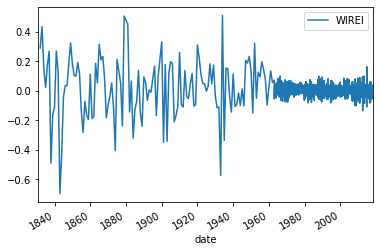

In [21]:
np.log(df_wirei/df_wirei.shift(1)).plot()

# 2. Preprocessing

## 1) Merge datasets
- `df_gfd`, `df_bbg`, `df_ry`, `df_wirei`
- Changing `date` formats to properly join

#### Change each index type to `PeriodIndex` with `_freq` frequency

In [22]:
if _freq == 'M':
    gfd_index = pd.to_datetime(df_gfd.index).to_period(_freq)
    bbg_index = pd.to_datetime(df_bbg.index).to_period(_freq)
    ry_index = pd.to_datetime(df_ry.index).to_period(_freq)
    wirei_index = pd.to_datetime(df_wirei.index).to_period(_freq)
elif _freq == 'W':
    gfd_index = pd.to_datetime(df_gfd.index - pd.Timedelta('1 days')).to_period('W-FRI')
    bbg_index = pd.to_datetime(df_bbg.index).to_period('W-FRI')   
    ry_index = pd.to_datetime(df_ry.index).to_period('M').asfreq('W-FRI', how='E')
    wirei_index = pd.to_datetime(df_wirei.index).to_period('M').asfreq('W-FRI', how='E')

In [23]:
df_gfd = df_gfd.set_index(gfd_index, drop=True)
df_bbg = df_bbg.set_index(bbg_index, drop=True)
df_ry = df_ry.set_index(ry_index, drop=True)
df_wirei = df_wirei.set_index(wirei_index, drop=True)

#### Joining all data sets to create `df`

In [24]:
df = pd.merge(df_bbg, df_gfd, how='left', left_index=True, right_index=True, suffixes=('_bbg', '_gfd'))
df = pd.merge(df, df_ry, how='left', left_index=True, right_index=True, suffixes=('', '_ry'))
df = pd.merge(df, df_wirei, how='left', left_index=True, right_index=True, suffixes=('', '_wirei'))

- `Riskfree_rate`:
  - July 1954 to present: Federal funds rates (df_bbg.**FF_rate**, daily)
  - February 22, 1934 to June 1954: USA Government 3-Month T-bills Auction Rate (**ITUSAA3W**, weekly)
  - January 1920 to February 1934: USA Government 3-Month T-Bills Constant Maturity Yield (**ITUSA3CMD**, monthly)

In [25]:
df['Rf_rate'] = df.FF_rate
df.Rf_rate.fillna(df.ITUSAA3W, inplace=True)
df.Rf_rate.fillna(df.ITUSA3CMD, inplace=True)

Data range is:

In [26]:
df.index.min(), df.index.max()

(Period('1947-12-20/1947-12-26', 'W-FRI'),
 Period('2020-11-14/2020-11-20', 'W-FRI'))

To rename the index name, we set *inplace=True* in order for the data frame to retain all its properties.
- https://stackoverflow.com/questions/19851005/rename-pandas-dataframe-index

In [27]:
df.index.rename('date', inplace=True)

In [28]:
df.columns

Index(['DMEQ_idx', 'EMEQ_idx', 'ACEQ_idx', 'TBILL3M_yld', 'UST_idx',
       'CRE_Baa_idx', 'CRE_Aaa_idx', 'TIPS_idx', 'GOLD_pr', 'NAREIT_idx',
       'UST_idx.1', 'WTI_pr', 'ENGY_idx', 'DXY_idx', 'USDCAD_rate_bbg',
       'USDNOK_rate_bbg', 'AUDUSD_rate_bbg', 'USDJPY_rate_bbg',
       'USDCHF_rate_bbg', 'TBILL_idx', 'SPX_idx', 'FF_rate', 'UST10YR_yld',
       'DMEQ_etf', 'UST_etf', 'TIPS_etf', 'DXY_etf', 'GOLD_etf', 'WTI_etf',
       'NAREIT_etf', 'CLI_TOTAL', 'CLI_USA', 'CPI_TOTAL', 'ISM_PMI', 'USCPI',
       'USGDP', 'AUDUSD_rate_gfd', 'CPUSAM', 'GBPUSD_rate', 'IGUSA10D',
       'ITUSA3CMD', 'ITUSAA3W', 'NBM13009USM156N', 'NBM16078USM509S',
       'TRUSABID', 'TRUSACOM', 'TRUSG10M', 'USDBEF_rate', 'USDCAD_rate_gfd',
       'USDCHF_rate_gfd', 'USDDEM_rate', 'USDFRF_rate', 'USDITL_rate',
       'USDJPY_rate_gfd', 'USDNLG_rate', 'USDNOK_rate_gfd', 'USDSEK_rate',
       '_DJCBPD', '_SPXD', '_TNXD', '__WTC_D', '__XAU_D', 'REAL7Y_yld',
       'REAL10Y_yld', 'WIREI', 'Rf_rate'],
      dtype

In [29]:
df.TBILL3M_yld.dropna()

date
1954-01-02/1954-01-08    1.3100
1954-01-09/1954-01-15    1.2000
1954-01-16/1954-01-22    1.0000
1954-01-23/1954-01-29    1.0200
1954-01-30/1954-02-05    0.9000
                          ...  
2020-10-17/2020-10-23    0.0862
2020-10-24/2020-10-30    0.0864
2020-10-31/2020-11-06    0.0862
2020-11-07/2020-11-13    0.0837
2020-11-14/2020-11-20    0.0634
Freq: W-FRI, Name: TBILL3M_yld, Length: 3490, dtype: float64

#### Drop rows where their data are invalid due to erroneous forward-fill.

In [30]:
if _freq == 'M':
    this_month = pd.Timestamp.today().to_period(_freq)
    df = df.loc[~(df.index==this_month), :]
elif _freq == 'W':
    this_week = pd.Timestamp.today().to_period('W-FRI')
    df = df.loc[~(df.index==this_week), :]

#### For each column, we fill nan rows with the lastest observation from the first valid row to the last valid row.
- We leave nan as it is for the rest of rows.

In [31]:
df = df.apply(lambda col: col.loc[col.first_valid_index():col.last_valid_index()].fillna(method='ffill'))

In [32]:
df

,DMEQ_idx,EMEQ_idx,ACEQ_idx,TBILL3M_yld,UST_idx,CRE_Baa_idx,CRE_Aaa_idx,TIPS_idx,GOLD_pr,NAREIT_idx,...,USDSEK_rate,_DJCBPD,_SPXD,_TNXD,__WTC_D,__XAU_D,REAL7Y_yld,REAL10Y_yld,WIREI,Rf_rate
date,,,,,,,,,,,,,,,,,,,,,
1947-12-20/1947-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.5884,109.708,15.1007,NaN,NaN,NaN,NaN,NaN,NaN,0.952
1947-12-27/1948-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,...,3.5884,109.934,15.3400,2.18,2.57,43.0,NaN,NaN,4969.84,0.950
1948-01-03/1948-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,...,3.5884,111.000,15.2645,2.18,2.57,43.0,NaN,NaN,4969.84,0.976
1948-01-10/1948-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,...,3.5884,111.137,14.8615,2.18,2.57,43.0,NaN,NaN,4969.84,0.981
1948-01-17/1948-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,...,3.5884,110.887,14.3577,2.18,2.57,43.0,NaN,NaN,4969.84,0.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-17/2020-10-23,7219.40,548.03,294.84,0.0862,124.9686,4466.270,2373.847,345.5637,1902.05,17101.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090
2020-10-24/2020-10-30,6811.78,532.17,279.22,0.0864,124.7953,4454.748,2372.370,344.4347,1878.81,16186.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090
2020-10-31/2020-11-06,7339.43,567.41,300.45,0.0862,125.1940,4523.526,2380.886,344.2269,1951.35,16844.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090


# 3. Generate `Base Asset` indices
- Data from **1921** to present. `FXCS` is the shortest data series and it starts from 1921.

#### `bf` is a DataFrame of base asset indices where its columns are base asset indices.

In [33]:
bf = pd.DataFrame(index = df.index)

#### Index names in `gray boxes`

### 1) Equities

`DMEQ` (Equities): Log returns of an equity index.
  - Since January 1970, **DMEQ_idx**: MSCI World in USD.
  - Before that date, **_SPXD**: S&P (500)

In [38]:
df['DMEQ_recent'] = np.log(df.DMEQ_etf[df.DMEQ_etf.index >= '2016-11-30'] / df.DMEQ_etf[df.DMEQ_etf.index >= '2016-11-30'].shift(1))
df['DMEQ_older'] = np.log(df.DMEQ_idx/df.DMEQ_idx.shift(1))
df['DMEQ_oldest'] = np.log(df._SPXD/df._SPXD.shift(1))

In [41]:
dmeq_rev = df.DMEQ_recent.fillna(df.DMEQ_older).fillna(df.DMEQ_oldest)

#### Take log returns

In [42]:
df['DMEQ_recent'] = np.log(df.DMEQ_idx/df.DMEQ_idx.shift(1))
df['DMEQ_older'] = np.log(df._SPXD/df._SPXD.shift(1))

#### Merge two columns to create `DMEQ`

In [43]:
bf['DMEQ'] = df.DMEQ_recent.fillna(df.DMEQ_older)

In [58]:
pd.concat((bf.DMEQ, dmeq_rev, bf.DMEQ-dmeq_rev), axis=1)

,DMEQ,DMEQ_recent,0
date,,,
1947-12-20/1947-12-26,NaN,NaN,NaN
1947-12-27/1948-01-02,0.015723,0.015723,0.000000
1948-01-03/1948-01-09,-0.004934,-0.004934,0.000000
1948-01-10/1948-01-16,-0.026756,-0.026756,0.000000
1948-01-17/1948-01-23,-0.034488,-0.034488,0.000000
...,...,...,...
2020-10-17/2020-10-23,-0.003827,-0.002732,-0.001095
2020-10-24/2020-10-30,-0.058118,-0.058447,0.000328
2020-10-31/2020-11-06,0.074608,0.073768,0.000840


`Rf` is a series of `_freq` risk-free log returns.
  - January 1993 to present **TBILL_idx**: Bloomberg Barclays US T-Bills 1-3 Months TR Index Value Unhedged
  - Before that date, **TRUSABID**: GFD Indices USA Total Return Daily T-Bill Index

In [36]:
df['Rf_recent'] = np.log(df.TBILL_idx/df.TBILL_idx.shift(1))
df['Rf_older'] = np.log(df.TRUSABID/df.TRUSABID.shift(1))

In [37]:
df['Rf_ret'] = df.Rf_recent.fillna(df.Rf_older)

In [38]:
bf['DMEQ'] = bf['DMEQ'] - df.Rf_ret

### 2) Treasuries

`UST` (Treasuries): Log returns of a U.S. government bond index.
- Since January 2005, **UST_idx**: ICE U.S. Treasury 7-10 Year TR Index.
  - We choose this index instead of Blomberg Barclays US Treasury Total Return Unhedged USD Index (LUATTRUU) because **IEF US** tracks the index.
  - YAS Modified duration of **UST_idx** is 7.547. Matury is 8.46 as of April 28, 2019.
- Before that date, **TRUSG10M**: GFD Indices USA 10-year Government Bond Total Return Index.

In [39]:
df['UST_recent'] = np.log(df.UST_idx/df.UST_idx.shift(1))
df['UST_older'] = np.log(df.TRUSG10M/df.TRUSG10M.shift(1))
bf['UST'] = df.UST_recent.fillna(df.UST_older) - df.Rf_ret

### 3) Credit

`CRE` (Credit): Log returns of Baa-rating index - log returns of Aaa-rating index.
  - February 1973 to present: **CRE_Baa_idx**: Bloomberg Barclays U.S. Credit Baa index vs. **CRE_Aaa_idx**: Bloomberg Barclays U.S. Credit Aaa index.
  - Before this date: **_DJCBPD**: Dow Jones Corporate Bond Price Index (new) vs. **TRUSACOM**: GFD Indices USA Total Return AAA Corporate Bond Index.
    - In contrast to its name, **_DJCBPD** is a total return index.

In [40]:
df['CRE_recent'] = np.log(df.CRE_Baa_idx/df.CRE_Baa_idx.shift(1)) - np.log(df.CRE_Aaa_idx/df.CRE_Aaa_idx.shift(1))
df['CRE_older'] = np.log(df._DJCBPD/df._DJCBPD.shift(1)) - np.log(df.TRUSACOM/df.TRUSACOM.shift(1))
bf['CRE'] = df.CRE_recent.fillna(df.CRE_older) - df.Rf_ret

### 4) Inlfation-Linked Bond

`ILB` (Inflation-Linked Bonds): Real log returns. - Nominal log returns. That is, `ILB` is a series of outperformances of TIPS against their U.S. Treasury counterparts on the same maturity.
- df.`ILB_recent`: January 2003 to present. **TIPS_idx**: Log returns of Bloomberg Barclays U.S. TIPS ("*real return*") - **UST_idx** Bloomberg Barclays U.S. Treasury Total Return Unhedged USD ("*nominal return*")
  - We don't use TIPS returns for a period of 1997 to 2002, when TIPS existed, because their trading volumes are low, lowering their accruracy as real returns.
- df.`ILB_older`: Before that date. `REALBOND8Y_logreturn`: *Derived* real log returns - **UST_idx**  Bloomberg Barclays U.S. Treasury Total Return Unhedged USD.

`ILB` (Inflation-Linked Bonds): Log returns of a U.S. government bonx index `UST` - log returns of TIPS on the same maturity **TIPS_idx**. Conceptually it's returns derived from *breakeven inflation rates*. Since a nominal return can be decomposed as:
$$
\begin{align}
r^{Nominal} &= r^{Real} + r^{Expected\ inflation} + r^{Inflation-risk\ premium} + r^{Liquidity-risk\ premium} \\
            &= r^{Real} + r^{Breakeven\ inflation} \\
\Leftrightarrow r^{Breakeven\ inflation} &= r^{Nominal} - r^{Real}
\end{align}
$$
, where $r^{Nominal}$ is a 10-year Treasury yield and $r^{Real}$ is a 10-year TIPS yield. If this equation holds, owning 10-year Treasury and 10-year TIPS would be indifferent assuming an average of CPI over the next 10 years equals to $r^{Breakeven\ inflation}$.

By defining `ILB` as above, we can say that the higher `ILB`, the greater a realized CPI than the current $r^{Breakeven\ inflation}$ over 10 years. Keep in mind that `ILB` is a series of ***return*** differences, not rate differences.
  -  A breakeven inflation rate (**BEI**) is believed to be a leading indicator of CPI. Since we will get an `ILB` exposure through TIPS, we are assuming: $$\textrm{ILB} \propto \textrm{BEI}.$$
Therefore, we define, again: `ILB` = rate of returns of nominal bonds - rate of returns of TIPS on the same maturity (8 years in this case because we choose to match it to an ETF duration).
  - Since January 2003, **UST_idx** Bloomberg Barclays U.S. Treasury Total Return Unhedged USD ("*nominal return*") vs. **TIPS_idx**: Log returns of Bloomberg Barclays U.S. TIPS ("*real return*").
    - We don't use TIPS returns for before this date because their trading volumes are low, lowering their accruracy as real returns.
  - From January 1972 to December 2002, **UST_idx** Bloomberg Barclays U.S. Treasury Total Return Unhedged USD ("*nominal return*") vs. **derived** real bond returns `REALBOND8Y_logreturn`. We derive real bond returns using historical real yield stored in `df_ry`.
  - Before that date, we use a centered moving average of CPI to approximate inflation forecasts, which in turns will be used as $r^{Expected\ inflation}$, which is assumed to be equivalent to $r^{Breakeven\ inflation}$, as discussed in Swinkels (2018). Now we can get real yields simply by taking the difference; $r^{Nominal} - r^{Breakeven\ inflation}$. Finally, we calculate `ILB` from these replicated real yields as we do above.
    - $r^{Breakeven\ inflation}$ for this period is log returns of $$\frac{1}{3}(CPI_{t-1}+CPI_{t}+CPI_{t+1})$$, where $CPI_t$ is CPUSAM/CPUSAM.shift(12)-1, **CPUSAM**: United States BLS Consumer Price *Index* Inflation Rate NSA. CPUSAM.shift(12): one-year ago; t: present; CPUSAM.shift(-12): one-year ahed.

#### (1) January 2002 to present

In [41]:
df['ILB_recent'] = np.log(df.TIPS_idx/df.TIPS_idx.shift(1)) - bf.UST

As discussed above, `ILB_recent` is defined since 2003. So, remove all data points before this date.

In [42]:
df.loc[df.index.year < 2002, 'ILB_recent'] = np.nan

#### (2) December 1852 ~ December 2002

i) Get **real yields** for this pre-2003 period first.
- We get a proxy of breakeven inflation rates (BEI) through a centered moving average of CPIs. Then we transform it to a series of real rates in log term.
  - Real rates `real_yld` = Nominal bond rates - BEI = **_TNXD** CBOE 10-year US Government Bond Yield Index - `breakeven`
- Real rates in log term = ln(1 + `real_yld`)

We will call those real rates `REAL8Y_logyld`. Its maturity is not really 8 years, but we choose to call it 8-year because we need 8-year real rates to match the maturity of TIPS ETF, an instrument which we end up with having in a portfolio.

In [43]:
if _freq == 'M':
    one_yr = 12
    two_yrs = 24
elif _freq == 'W':
    one_yr = 52
    two_yrs = 104

In [44]:
df['breakeven'] =((df.CPUSAM.shift(one_yr)/df.CPUSAM.shift(two_yrs)-1) + (df.CPUSAM/df.CPUSAM.shift(one_yr)-1) + (df.CPUSAM.shift(-one_yr)/df.CPUSAM-1))/3
df['real_yld'] = df._TNXD/100 - df.breakeven

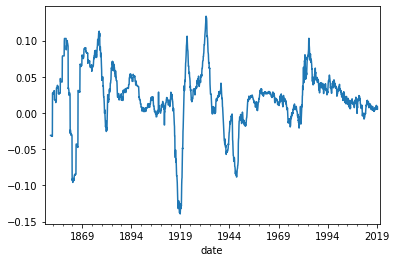

In [45]:
df['real_yld'].plot()

ii) Real yields in log term for December 1852 to December 1971

In [46]:
df['REAL8Y_logyld'] = np.log(1+df.loc[df.index.year < 1972, 'real_yld'])
df['REAL7Y_logyld'] = np.log(1+df.loc[df.index.year < 1972, 'real_yld'])

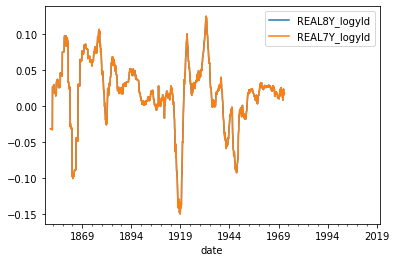

In [47]:
df.loc[:, ['REAL8Y_logyld', 'REAL7Y_logyld']].plot()

iii) Real yields for a period of 1972 to 2002.
- We have already loaded 7-year and 10-year real yields in `REAL7Y_yld` and `REAL10Y_yld` from 1972 to 2002 on a quarterly basis.
- We want to generate 8-year real yields

`avg_diff_in_logyld` is for making 7-year real yield from 8-year one. It's arbitrary and no strong ground.

In [48]:
real7y_logyld = np.log(1+df.REAL7Y_yld)
real8y_logyld = np.log(1 + (2*df.REAL7Y_yld + df.REAL10Y_yld)/3)
avg_diff_in_logyld = np.average((real8y_logyld-real7y_logyld).dropna(how='any'))

In [49]:
real8y_logyld.dropna()

date
1971-09    0.027411
1971-10    0.027411
1971-11    0.027411
1971-12    0.023658
1972-01    0.023658
             ...   
2002-08    0.018684
2002-09    0.012414
2002-10    0.012414
2002-11    0.012414
2002-12    0.012952
Freq: M, Length: 376, dtype: float64

- Merge them into df.`REAL7Y_logyld` and df.`REAL8Y_logyld`.

In [50]:
df['REAL8Y_logyld'] = df.REAL8Y_logyld.fillna(real8y_logyld)
df['REAL7Y_logyld'] = df.REAL7Y_logyld.fillna(real7y_logyld)

For the pre-1972 period `REAL7Y_logyld`, we define it as the `real_yld` - an average difference between 8-year log yields and 7-year log yields both of which were from `df_ry`.

In [51]:
df['REAL7Y_logyld'] = df['REAL7Y_logyld'] - avg_diff_in_logyld

In [52]:
df.loc[:, ['REAL7Y_logyld', 'REAL8Y_logyld']].dropna()

,REAL7Y_logyld,REAL8Y_logyld
date,,
1852-12,-0.031816,-0.031426
1853-01,-0.031708,-0.031317
1853-02,-0.032031,-0.031640
1853-03,-0.032137,-0.031747
1853-04,-0.032031,-0.031640
...,...,...
2002-08,0.017113,0.018684
2002-09,0.010720,0.012414
2002-10,0.010720,0.012414


iv) Derive **real bond returns**.
- This follows Swinkels (2018), "Simulating historical inflation-linked bond returns."


We set a duration `D` = 8 for all this calculation process to be in line with the modified duration of **TIP US** of 8.06 as of April 28, 2020.  

In [53]:
D = 8
df['REALBOND8Y_logreturn'] = (D*df.REAL8Y_logyld - (D-1)*df.REAL7Y_logyld.shift(-12))/12

#### *LIMITATION*: Derived real bond returns in blue show *much smaller volatility* than TIPS returns in orange.
- Check out how similar derived real bond returns and TIPS returns are.
- Derived returns are obviously less volatile, but they seem to well replicate TIPS returns.

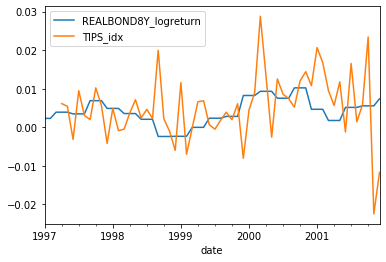

In [54]:
tips_return = np.log(df.TIPS_idx/df.TIPS_idx.shift(1))
compare_rr = pd.merge(df['REALBOND8Y_logreturn'], tips_return, how='inner', on='date')
compare_rr.loc[np.logical_and(compare_rr.index.year>1996, compare_rr.index.year<2002), :].plot()

Older derived real bond returns seem to be more volatile, though.

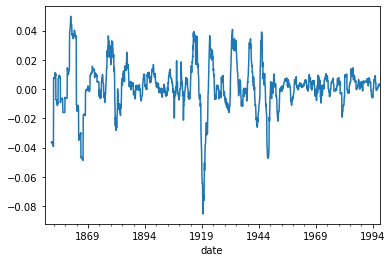

In [55]:
df.loc[df.index.year<1997, 'REALBOND8Y_logreturn'].plot()

In [56]:
df['ILB_older'] = df.REALBOND8Y_logreturn - bf.UST

In [57]:
bf['ILB'] = df.ILB_recent.fillna(df.ILB_older) - df.Rf_ret

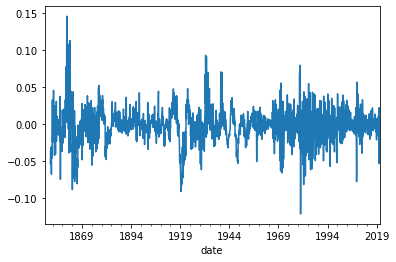

In [58]:
bf.ILB.plot()

### 5) U.S. Dollar

`DXY` (Dollar Index): Log returns of the U.S. Dollar Index.
  - Since February 1967, **DXY_idx**: U.S. Dollar Index
  - Before that date, we use a *derived* DXY index by taking an equally-weighted basket of major currencies in that period except of USDEM due to the hyper-inflation in Germany. It's not G-10, but I'll call it G-10 anyway.

#### (1) February 1967 to present

In [59]:
df['DXY_recent'] = np.log(df.DXY_idx/df.DXY_idx.shift(1))

#### (2) February 1850 to January 1967

In [60]:
g10 = ['USDBEF_rate', 'USDCAD_rate_gfd', 'USDFRF_rate', 'USDITL_rate', 'USDJPY_rate_gfd', 'USDNLG_rate', 'USDSEK_rate', 'USDCHF_rate_gfd', 'GBPUSD_rate' ]
df_g10 = df[g10]

Take a reciprocal of `GBPUSD_rate` to match its direction to that of the rest currencies.

In [61]:
df_g10['USDGBP_rate'] = np.reciprocal(df_g10.GBPUSD_rate)
df_g10 = df_g10.drop(['GBPUSD_rate'], axis=1)

- Recent European rates are distorted due to Euro introduction in 1999.
  - Doesn't matter. We don't use them since 1967 in this model.

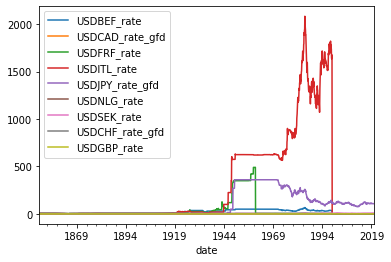

In [62]:
df_g10.plot()

Compute the mean for the monthly log returns of all currencies.

In [63]:
df_g10 = df_g10.apply(lambda col: np.log(col/col.shift(1)))

#### `USDFRF_rate` normailzation
- French Frac was revalued in January 1960 with each new franc being worth 100 old francs, and it resulted in *discontinuity* in raw data.
  - We normalize this particular month.

In [64]:
df_g10.loc['1960-01', 'USDFRF_rate'] =  np.log(df.loc['1960-01', 'USDFRF_rate']*100/df.loc['1959-12', 'USDFRF_rate'])

In [65]:
df_g10['avg'] = df_g10.mean(axis=1)

Let's see how much the *derived* DXY and original DXY show comovement. 
- Good enough.

In [66]:
ret_comp = pd.merge(df_g10.avg, df.DXY_recent, on='date', how='inner').loc[np.logical_and(df.index.year>1969,df.index.year<1999),:]
ret_comp.columns = ['DXY_derived', 'DXY']

In [67]:
ret_comp.columns

Index(['DXY_derived', 'DXY'], dtype='object')

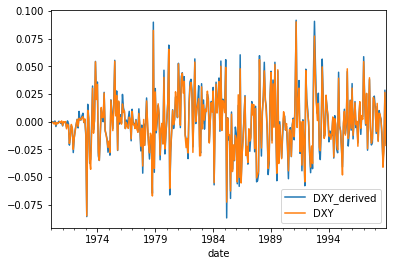

In [68]:
ret_comp.plot()

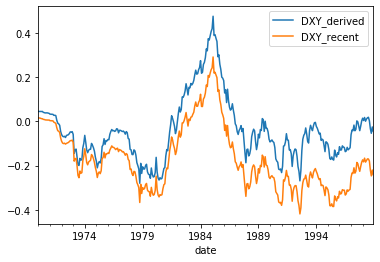

In [69]:
df_g10['DXY_derived'] = df_g10.loc[df.DXY_idx.first_valid_index():, 'avg'].cumsum()
pd.merge(df_g10['DXY_derived'], df.DXY_recent.cumsum(), on='date', how='inner').loc[np.logical_and(df.index.year>1969,df.index.year<1999),:].plot()

In [70]:
df['DXY_older'] = df_g10['avg']
bf['DXY'] = df.DXY_recent.fillna(df.DXY_older) - df.Rf_ret

### 6) Commodity vs. Safe haven currency

`FXCS` (FX Commodity vs. Safe haven): Log returns of commidity currencies - log returns of safe haven currencies.
- df.`FXCS_recent`: January 1987 to present. An equally-weighted basket of **USDCAD_rate_bbg**, **USDNOK_rate_bbg** and **USDAUD_rate_bbg** vs. **USDCHF_rate_bbg** and **USDJPY_rate_bbg**.
- df.`FXCS_80s`: January 1980 to December 1986. An equally-weighted basket of **USDCAD_rate_bbg**, **USDNOK_rate_bbg** and **USDAUD_rate_bbg** vs. **USDCHF_rate_bbg** ; **USDJPY_bbg_rate** is excluded.
  - Rationale: I searched through WSJs in my news archive and found out that Japanese Yen started to be considered a *safe haven* currency as early as 1987.
- df.`FXCS_70s`: January 1972 to December 1979. An equally-weighted basket of **USDCAD_rate_bbg** and **USDAUD_rate_bbg** vs. **USDCHF_rate_bbg**; **USDNOK_bbg_rate** is further excluded.
  - Rationale: Norway's % of GDP has been around mid-teen numbers since 1980 for oil and oil-relevant products. So we consider NOK as a commidity currency from 1980.
- df.`FXCS_oldest`: 1921 - 1972. **USDCAD_rate_gfd**, **USDAUD_rate_gfd** vs. **USDCHF_rate_gfd**

Take a reciprocal to match a direction.

In [71]:
df['USDAUD_rate_bbg'] = np.reciprocal(df.AUDUSD_rate_bbg)
df['USDAUD_rate_gfd'] = np.reciprocal(df.AUDUSD_rate_gfd)

In [72]:
df['FXCS_recent'] = (np.log(df.USDCAD_rate_bbg / df.USDCAD_rate_bbg.shift(1)) + \
                     np.log(df.USDNOK_rate_bbg / df.USDNOK_rate_bbg.shift(1)) + \
                     np.log(df.USDAUD_rate_bbg / df.USDAUD_rate_bbg.shift(1))) - \
                    (np.log(df.USDCHF_rate_bbg / df.USDCHF_rate_bbg.shift(1)) + \
                     np.log(df.USDJPY_rate_bbg / df.USDJPY_rate_bbg.shift(1))) \

df['FXCS_80s'] = (np.log(df.USDCAD_rate_bbg / df.USDCAD_rate_bbg.shift(1)) + \
                  np.log(df.USDNOK_rate_bbg / df.USDNOK_rate_bbg.shift(1)) + \
                  np.log(df.USDAUD_rate_bbg / df.USDAUD_rate_bbg.shift(1))) - \
                 (np.log(df.USDCHF_rate_bbg / df.USDCHF_rate_bbg.shift(1)))

df['FXCS_70s'] = (np.log(df.USDCAD_rate_bbg / df.USDCAD_rate_bbg.shift(1)) + \
                  np.log(df.USDAUD_rate_bbg / df.USDAUD_rate_bbg.shift(1))) - \
                 (np.log(df.USDCHF_rate_bbg / df.USDCHF_rate_bbg.shift(1)))

df['FXCS_oldest'] = (np.log(df.USDCAD_rate_gfd / df.USDCAD_rate_gfd.shift(1)) + \
                     np.log(df.USDAUD_rate_gfd / df.USDAUD_rate_gfd.shift(1))) - \
                    (np.log(df.USDCHF_rate_gfd / df.USDCHF_rate_gfd.shift(1)))

In [73]:
fxcs_recent_idx = df.index.year >= 1987
fxcs_80s_idx = np.logical_and(df.index.year >= 1980, df.index.year <= 1986)
fxcs_70s_idx = np.logical_and(df.index.year >= 1972, df.index.year <= 1979)
fxcs_oldest_idx = np.logical_and(df.index.year >= 1900, df.index.year < 1972)

In [74]:
bf.loc[fxcs_recent_idx, 'FXCS'] = df.loc[fxcs_recent_idx, 'FXCS_recent']
bf.loc[fxcs_80s_idx, 'FXCS'] = df.loc[fxcs_80s_idx, 'FXCS_80s']
bf.loc[fxcs_70s_idx, 'FXCS'] = df.loc[fxcs_70s_idx, 'FXCS_70s']
bf.loc[fxcs_oldest_idx, 'FXCS'] = df.loc[fxcs_oldest_idx, 'FXCS_oldest']

#### Outlier detection
- We manually take a close look at the `FXCS` plot for pre-free-floating regime periods.
  - Free floating exchange rates were introduced on  

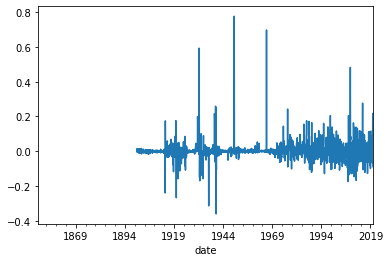

In [75]:
bf.FXCS.plot()

##### The interwar period: 1913-1945

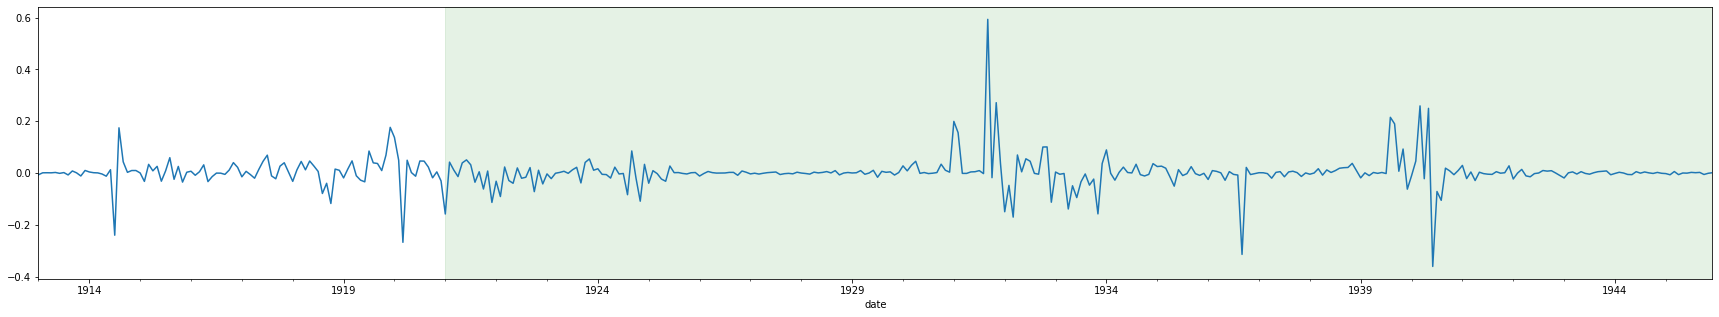

In [76]:
ax = bf.FXCS.loc[np.logical_and(bf.index.year>=1913, bf.index.year<=1945)].plot(figsize=(30,5))
period_used_min = min(df.loc[df.index.year==1921].index).to_timestamp()
ax.axvspan(period_used_min, max(df.index), alpha=0.1, color='g')

- 1914-1915: **Accepted.** Seems reasonable given World War I, which lasted July 1914 to November 1918.

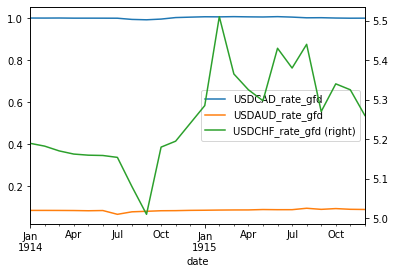

In [77]:
df.loc[np.logical_and(df.index.year>=1914, df.index.year<=1915), ['USDCAD_rate_gfd', 'USDAUD_rate_gfd', 'USDCHF_rate_gfd']].plot(secondary_y=['USDCHF_rate_gfd'])

- 1919-1921: **Accepted.** USDCHF seems to be considered a safe haven from early 20th century, except of the **short post-war period** in which USD prevailed over CHF. This implies that we `CHF` has been considered a `safe haven` currency even against USD since 1921 and therefore we choose to use `FXCS` from that year, 1921.
  - The rise of the Swiss tax haven in the interwar peirod, pp 5-6.
  - http://www.ehes.org/EHES_No27.pdf
- 1918-1920: **Accepted.** CAD weakened due to a siginificant monetary expansion, high inflation and a deterioration in Canada's balance of payments associatged with financing the war effort.

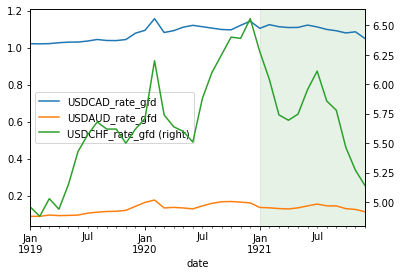

In [78]:
ax = df.loc[np.logical_and(df.index.year>=1919, df.index.year<=1921), ['USDCAD_rate_gfd', 'USDAUD_rate_gfd', 'USDCHF_rate_gfd']].plot(secondary_y=['USDCHF_rate_gfd'])
period_used_min = min(df.loc[df.index.year==1921].index).to_timestamp()
ax.axvspan(period_used_min, max(df.index), alpha=0.1, color='g')

- 1933-1934: **Accepted**. CHF proved its safe haven status in this period of USD devaluation.
  - USD started to be devalued against CHF since March 1933 because of gold outflows and the U.S. administrating weakening their USD link to gold. This gold drain was caused when the FRBNY could no longer convert USD to gold in March 1933 due to the aftermath of Great Depression in 1929.
  - This devaluation returned to stability in January 1934 where *Gold Reserve Act of 1934* reduced the gold value of the dollar to 59 percent of the value set by the Gold Act of 1900. That is, from $35 per ounce to $20.67 per ounce
    - https://www.federalreservehistory.org/essays/gold_reserve_act

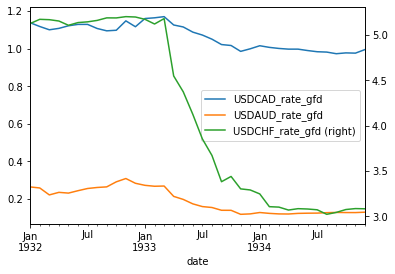

In [79]:
df.loc[np.logical_and(df.index.year>=1932, df.index.year<=1934), ['USDCAD_rate_gfd', 'USDAUD_rate_gfd', 'USDCHF_rate_gfd']].plot(secondary_y=['USDCHF_rate_gfd'])

- September 1936: **Accepted.** CHF was devalued by the same proportion, 30%, as French franc.
  - 1930s is the period of devluations; British pound devalued in September 1931, USD in April 1933.

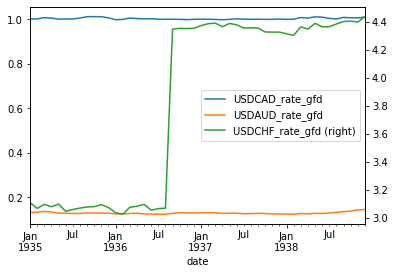

In [80]:
df.loc[np.logical_and(df.index.year>=1935, df.index.year<=1938), ['USDCAD_rate_gfd', 'USDAUD_rate_gfd', 'USDCHF_rate_gfd']].plot(secondary_y=['USDCHF_rate_gfd'])

- 1939-1940: **Accepted.** Those currencies were just fluctuated a little due to World War II that began on September 1, 1939.

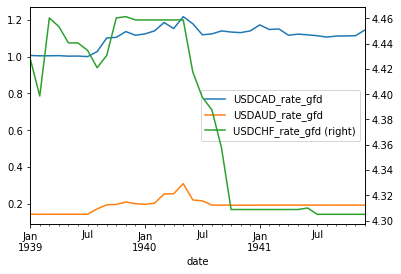

In [81]:
df.loc[np.logical_and(df.index.year>=1939, df.index.year<=1941), ['USDCAD_rate_gfd', 'USDAUD_rate_gfd', 'USDCHF_rate_gfd']].plot(secondary_y=['USDCHF_rate_gfd'])

##### Post-war to the collapse of the Bretton Woods system: 1945 to 1971.

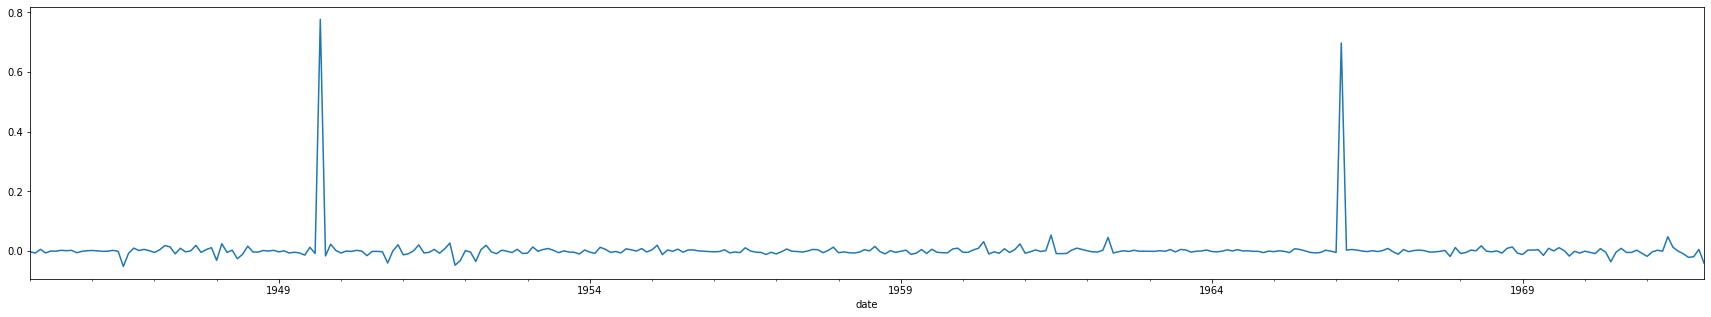

In [82]:
bf.FXCS.loc[np.logical_and(bf.index.year>=1945, bf.index.year<=1971)].plot(figsize=(30,5))

- September 1949: **Accepted.** Aussie was devalued by 30% following UK's move in September 1949 in order not to experience an over-valued currency relative to its Sterling zone countries.

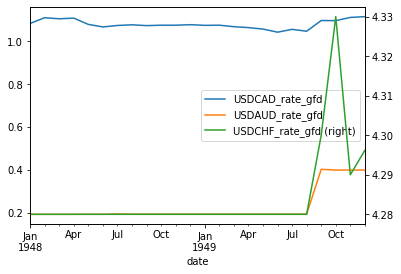

In [83]:
df.loc[np.logical_and(df.index.year>=1948, df.index.year<=1949), ['USDCAD_rate_gfd', 'USDAUD_rate_gfd', 'USDCHF_rate_gfd']].plot(secondary_y=['USDCHF_rate_gfd'])

- February 1966: Changeover day. **Not accepted. To be normalized.** AUD was introduced on February 14, 1966 to replace the Australlian pound with the conversion rate of A$2 = A₤1. This is *not* a devaluation process.
  - How to normalize: The legacy Austallian pound on February 28, 1966 would have been exactly 2 times that on January 31, 1966 if no changeover day occurred; 2*0.401434 = 0.802868. So, a log return = log(USDAUD on Feb / 0.802868).

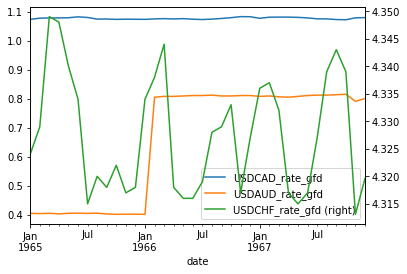

In [84]:
df.loc[np.logical_and(df.index.year>=1965, df.index.year<=1967), ['USDCAD_rate_gfd', 'USDAUD_rate_gfd', 'USDCHF_rate_gfd']].plot(secondary_y=['USDCHF_rate_gfd'])

`usdaud_logret` is a normalized log return for February 1966.

In [85]:
usdaud_logret = np.log(df.USDAUD_rate_gfd.loc['1966-02']/(2*df.USDAUD_rate_gfd.loc['1966-01']))
bf.FXCS.loc['1966-02'] = np.log(df.USDCAD_rate_gfd.loc['1966-02']/df.USDCAD_rate_gfd.loc['1966-01']) + usdaud_logret - np.log(df.USDCHF_rate_gfd.loc['1966-02']/df.USDCHF_rate_gfd.loc['1966-01'])

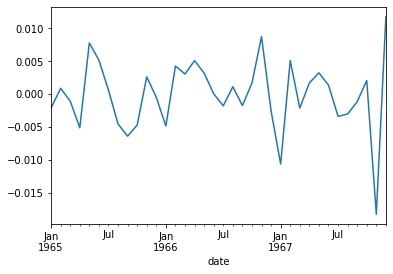

In [86]:
bf.FXCS.loc[np.logical_and(bf.index.year>=1965, bf.index.year<=1967)].plot()

##### Since 1972

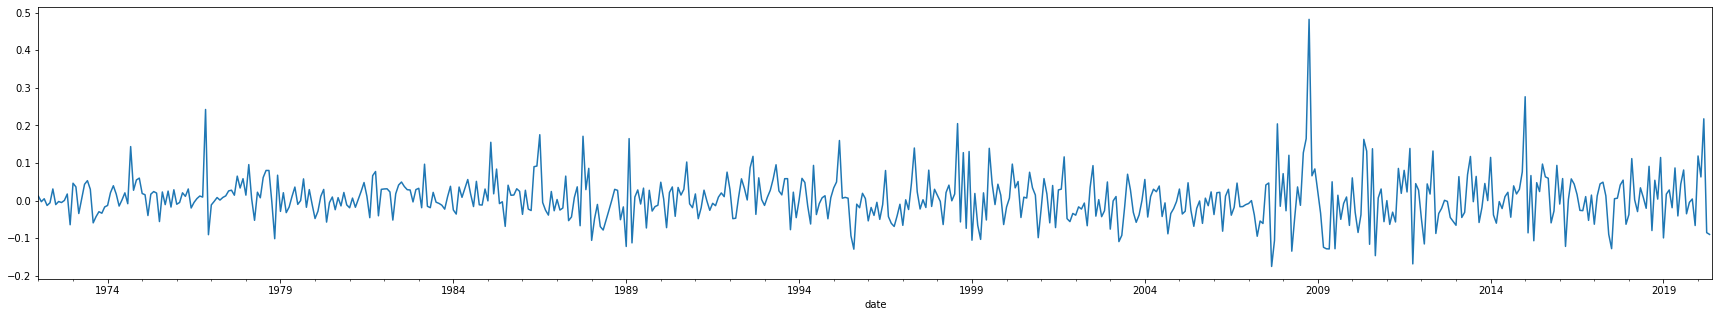

In [87]:
bf.FXCS.loc[bf.index.year>=1972].plot(figsize=(30,5))

- November 1976: **Accepted.** The Australia government devalued AUD by 17.5%.
- The first half of 1983: **Accepted.** AUD was depreciated by 10 percent in the first half of the year.
  - https://www.rba.gov.au/publications/confs/1993/blundell-wignall-fahrer-heath.html

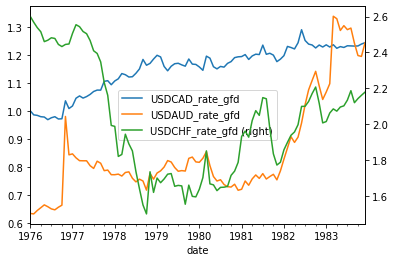

In [88]:
df.loc[np.logical_and(df.index.year>=1976, df.index.year<=1983), ['USDCAD_rate_gfd', 'USDAUD_rate_gfd', 'USDCHF_rate_gfd']].plot(secondary_y=['USDCHF_rate_gfd'])

#### The end of outlier detections for `FXCS`
- No suspicious data point observed after 1983.

In [89]:
bf['FXCS'] = bf['FXCS'] - df.Rf_ret

### 7) GOLD

`GOLD` (GOLD): Log returns of gold prices
- Since January 1959, **GOLD_pr**: gold price (ounce/USD)
- Before this date, **__XAU_D**: gold price (ounce/USD)

In [90]:
df['GOLD_recent'] = np.log(df.GOLD_pr/df.GOLD_pr.shift(1))
df['GOLD_older'] = np.log(df.__XAU_D/df.__XAU_D.shift(1))
bf['GOLD'] = df.GOLD_recent.fillna(df.GOLD_older) - df.Rf_ret

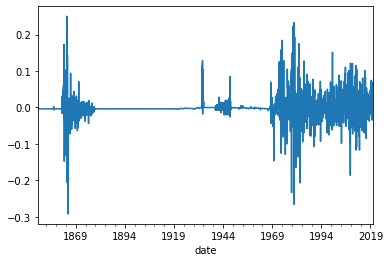

In [91]:
bf.GOLD.plot()

### 8) Energy

`ENGY` (Energy): Log returns of WTI Crude Oil prices
- Since January 1984, **WTI_pr**: Generic 1st Crude Oil prices, WTI.
- Before that date, **__WTC_D**

In [92]:
df['ENGY_recent'] = np.log(df.WTI_pr.loc[df.index.year>=1984]/df.WTI_pr.loc[df.index.year>=1984].shift(1))
df['ENGY_older'] = np.log(df.__WTC_D/df.__WTC_D.shift(1))
bf['ENGY'] = df.ENGY_recent.fillna(df.ENGY_older) - df.Rf_ret

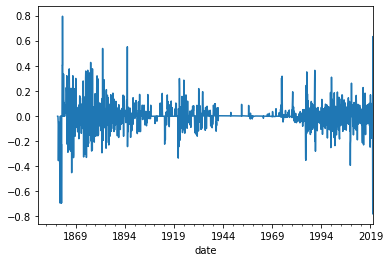

In [93]:
bf.ENGY.plot()

### 9) REITs

`REIT` (REITs): Log returns of a real estate index
- Since January 1972, **NAREIT_idx**: FTSE NAREIT Equity REITs Total Return Index USD
- Before this date, **WIREI**: Winan Real Estate Index

In [94]:
df['REIT_recent'] = np.log(df.NAREIT_idx/df.NAREIT_idx.shift(1))
df['REIT_older'] = np.log(df.WIREI/df.WIREI.shift(1))
bf['REIT'] = df.REIT_recent.fillna(df.REIT_older) - df.Rf_ret

- Let's check how much simular **WIREI** is with a well-known REITs index, FTSE NAREIT Index **NAREIT_idx**

In [95]:
compare_reit = pd.merge(df.WIREI, df.NAREIT_idx, on='date')
compare_reit.WIREI = np.log(compare_reit.WIREI/compare_reit.WIREI.dropna().iloc[0])
compare_reit.NAREIT_idx = np.log(compare_reit.NAREIT_idx/compare_reit.NAREIT_idx.dropna().iloc[0])

As expected, log returns of `WIREI` are much soomther than those of `NAREIT_idx` due to its nature of illiquidity.
- Still, we can use `WIREI` for the older period, or pre-1972, because `WIREI` is volatile enough for that period.

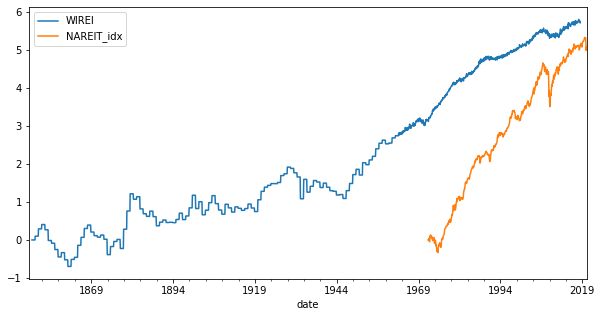

In [96]:
compare_reit.plot(figsize=(10,5))

The final data set for Base Assets Indices starts from 1921, but we drop data before 1916 instead of 1921 to allow us to have some lookback periods even in early 1920s.

In [97]:
bf = bf.loc[bf.index.year>=1916]

In [98]:
bf

,DMEQ,UST,CRE,ILB,DXY,FXCS,GOLD,ENGY,REIT
date,,,,,,,,,
1916-01,-0.019771,-0.006084,-0.004893,0.039087,0.005558,0.002992,-0.003822,0.039663,-0.003822
1916-02,-0.017607,0.015667,-0.007714,0.012229,-0.004249,-0.012313,-0.003575,0.017478,-0.003575
1916-03,-0.007088,0.000653,-0.006485,0.026752,-0.007308,0.001159,-0.003822,0.076221,-0.003822
1916-04,-0.014663,-0.005933,-0.009748,0.019375,-0.014926,0.027808,-0.003698,-0.003698,-0.003698
1916-05,0.017989,0.007402,-0.002768,0.006527,-0.002723,-0.036994,-0.003822,-0.003822,-0.003822
...,...,...,...,...,...,...,...,...,...
2020-02,-0.089644,0.029440,-0.009011,-0.017026,0.006257,0.061670,-0.003519,-0.142764,-0.084784
2020-03,-0.144029,0.033896,-0.116444,-0.053702,0.007222,0.215589,-0.007451,-0.783936,-0.249508
2020-04,0.103631,0.005420,0.047135,0.021966,-0.000372,-0.085269,0.066968,-0.083516,0.079711


## Save work

In [99]:
price_filename = '../../data/processed/asset_prices_' + _freq
dataset_filename = '../../data/processed/base_assets_' + _freq

df.to_csv(price_filename + '.log')
df.to_pickle(price_filename + '.pkl')
bf.to_csv(dataset_filename + '.log')
bf.to_pickle(dataset_filename + '.pkl')

# 3. Generate features for `KKT` index
- Features: `IP` (Industrial production), `NP` (Nonfarm payrolls), `SPX` (S&P 500) and `YC` (Yield curve)
  - Transformation: One-year percentage changes for the first three features and 10-year rate minus the Federal Funds Rate for `YC`

Source: A New Index of the Business Cycle, StateStreet. Published on January 15, 2020.
- https://www.statestreet.com/ideas/state-street-associates/a-new-index-of-the-business-cycle.html

### (1) Feature definitions
#### (1) `IP` (Industrial Production): the one-year percentage change in the monthly Industrial Production Index
- Since January 1920 to present: **IP_idx**
- Before that date: Index of Industrial Production and Trade, **IPT_idx**

#### (2) `NP` (Nonfarm Payrolls): the one-year percentage change in monthly Nonfarm Payrolls
- Since January 1940 to present: **NP_idx**
- Before that date: Index of Factory Payrolls for the state of New York, **FP_idx**

#### (3) `SPX` (S&P 500):  the one-year price return of the S&P 500 Composite Index
- Since January 1948 to present: **SPX_idx**
- Before that date: **_SPXD**

#### (4) `YC` (Yield Curve): the average difference between the 10-year U.S. treasury yield and the U.S. Federal Funds Rate over the preceding 12 months which is sourced captured on the 15th day of the reference month.
- `YC` is defined as Average(df_d.`UST10YR_yld` - df_d.`Rf_rate`) for the preceding 365 days.

### (2) Feature generation
#### (1) Risk-free rates: df_d.`Rf_rate` for `YC`
- We need the highest granular data of US Treasury 10-year yields and risk-free rates to construct `KKT` index.
- df_d.**Rf_rate** accounts for this granularity requirement:
  - July 1954 to present: Federal funds rates (df_bbg.**FF_rate**, daily)
  - February 22, 1934 to June 1954: USA Government 3-Month T-bills Auction Rate (**ITUSAA3W**, weekly)
  - January 1920 to February 1934: USA Government 3-Month T-Bills Constant Maturity Yield (**ITUSA3CMD**, monthly)
  - November 1914 to December 1919: FRBNY discount rates (**NBM13009USM156N**, monthly)

In [100]:
df_d = pd.DataFrame(index=pd.date_range(start='1/1/1910', end=pd.Timestamp.today(), freq='D'))

granular_filename = '../../data/raw/gfd_granular.log'
df_gr = pd.read_csv(granular_filename, header=0, parse_dates=['Date'])

In [101]:
df_gr = pd.pivot_table(df_gr, index=['Date'], columns=['Ticker'])
# Drop one of the top multi-index column, namely, "Close"
df_gr.columns = df_gr.columns.droplevel(0)

In [102]:
df_d['UST10YR_yld'] = df_bbg_d.UST10YR_yld
df_d['Rf_rate'] = df_bbg_d.FF_rate
df_d.Rf_rate.fillna(df_gr.ITUSAA3W['1934-02-22':'1954-06-30'], inplace=True)
df_d.Rf_rate.fillna(df_gr.ITUSA3CMD['1920-01-01':'1934-02-28'], inplace=True)
df_d.Rf_rate.fillna(df_gr.NBM13009USM156N['1914-11-01':'1919-12-31'], inplace=True)
ust10 = df.IGUSA10D
ust10.index =  ust10.index.to_timestamp(freq=_freq)
df_d.UST10YR_yld.fillna(ust10, inplace=True)
df_d = df_d.apply(lambda col: col.loc[col.first_valid_index():col.last_valid_index()].fillna(method='ffill'))
df_d.dropna(how='any', inplace=True)

#### (2) Generate features
- Collect macro data available **at each point in time**: `IP` and `NP`

In [103]:
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler
from fredapi import Fred
fred = Fred(api_key='98d7e668ce51c2997660ab73367c689a')

Get all revisions including the first releases available currently from FRED

In [104]:
ip_all = fred.get_series_all_releases('INDPRO')
np_all = fred.get_series_all_releases('PAYEMS')

In [105]:
kdf_older = {}
kdf_older['IPT_idx'] = fred.get_series_latest_release('M1204BUSM363SNBR')
kdf_older['FP_idx'] = fred.get_series_latest_release('M08G8AUS000NYM335NNBR')
kdf_older = pd.DataFrame(kdf_older)
kdf_older.set_index(kdf_older.index + MonthEnd(0), drop=True, inplace=True)

In [106]:
def get_asof_series_inc_rev(df, series_id, asof_date):
    '''
    Returns data for a Fred `series_id` available at a point of time specified by `as_of_date`.
    
    Parameters
    ----------
    df : DataFrame
        an object that's returned from fred.get_series_all_releases(`series_id`)
    
    series_id: string
        Fred's seried id such as 'INDPRO'
    
    asof_date: string or datetime
        a point of time
    
    
    Returns:
    DataFrame
        its index is reference date and column name is `series_id` unless specified differently in `col_nm`.
        
    '''

    # We extract conditions for 'realtime_start', 'date' so that we can extract data available at a point of time.
    cond_inc_rev = df.loc[df.realtime_start <= asof_date, ['realtime_start', 'date']].groupby(by='date').max().reset_index()
    
    # Filter `df` with `cond_inc_rev`
    ef = cond_inc_rev.merge(df, left_on=['date', 'realtime_start'], right_on=['date', 'realtime_start'], how='left')
    
    # Convert %m-01 format to %m-the last day of that month.
    ef['date'] = ef.date + MonthEnd(0)
    
    ef.set_index('date', drop=True, inplace=True)
    ef.drop('realtime_start', axis=1, inplace=True)
    
    ef.columns = [series_id]
    
    return ef

- The oldest data available is from June 1914. So we limit our search to that date.
- `kdf_asof` is a dictionary where its key is a point-in-time date and its corresponding value is a DataFrame object containing `IP_idx`, `NP_idx`, `IPT` and `FP` available at that point-in-time.

In [107]:
kdf_start_date = '1914-05-31'

if _freq == 'M':
    dt_range = pd.date_range(start=kdf_start_date, end=pd.Timestamp.today(), freq=_freq).strftime('%Y-%m-%d').to_list() + [pd.Timestamp.today().strftime('%Y-%m-%d')]
elif _freq == 'W':
    dt_range = pd.date_range(start=kdf_start_date, end=pd.Timestamp.today(), freq='W-FRI').strftime('%Y-%m-%d').to_list() + [pd.Timestamp.today().strftime('%Y-%m-%d')]
kdf_asof = {}

for dt in tqdm(dt_range):
    ip_idx = get_asof_series_inc_rev(ip_all, 'IP_idx', dt)
    np_idx = get_asof_series_inc_rev(np_all, 'NP_idx', dt)
    key = dt[:-3] if _freq == 'M' else dt
    kdf_asof[key] = pd.merge(pd.merge(ip_idx, np_idx, left_index=True, right_index=True, how='outer'), kdf_older, left_index=True, right_index=True, how='outer').loc[:dt]

    if _freq == 'M':
        kdf_asof_index = pd.to_datetime(kdf_asof[key].index).to_period(_freq)
    elif _freq == 'W':
        kdf_asof_index = pd.to_datetime(kdf_asof[key].index - pd.Timedelta('1 days')).to_period('W-FRI')
    kdf_asof[key] = kdf_asof[key].set_index(kdf_asof_index, drop=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [01:05<00:00, 19.40it/s]


In [108]:
import pickle
kdf_asof_filename = '../../data/processed/kdf_asof_dataset_' + _freq
with open(kdf_asof_filename + '.pkl', 'wb') as f:
    pickle.dump(kdf_asof, f)

All features are created in the following code cell.

In [109]:
kf_asof = {}

# `YC` is defined as follows:
yc_d = df_d.UST10YR_yld.rolling(window=365).mean() - df_d.Rf_rate.rolling(window=365).mean()

# Here, we should use shift(`one_yr`) to calculate a one-year price return, not shift(12), regardless of the value of `_freq`.
spx_recent = np.log(df.SPX_idx/df.SPX_idx.shift(one_yr))
spx_older = np.log(df._SPXD/df._SPXD.shift(one_yr))

for dt in tqdm(kdf_asof.keys()):
    # We do nothing if there's no data available on `dt` date.
    if kdf_asof[dt].empty:
        continue
        
    # Generate `IP` as of `dt` --------
    # Even when `_freq` is set to W, we should use shift(12) instead of shift(52) to get a one-year percentage change.
    kdf_asof[dt]['IP_recent'] = np.log((kdf_asof[dt].IP_idx/kdf_asof[dt].IP_idx.shift(12)).astype(float))
    kdf_asof[dt]['IP_older'] = np.log((kdf_asof[dt].IPT_idx/kdf_asof[dt].IPT_idx.shift(12)).astype(float))
    kf_asof[dt] = pd.DataFrame(index=df.index[df.index<=dt])
    kf_asof[dt]['IP'] = kdf_asof[dt].IP_recent.fillna(kdf_asof[dt].IP_older)
    
    # Generate `NP` as of `dt` --------
    kdf_asof[dt]['NP_recent'] = np.log((kdf_asof[dt].NP_idx/kdf_asof[dt].NP_idx.shift(12)).astype(float))
    kdf_asof[dt]['NP_older'] = np.log((kdf_asof[dt].FP_idx/kdf_asof[dt].FP_idx.shift(12)).astype(float))
    kf_asof[dt]['NP'] = kdf_asof[dt].NP_recent.fillna(kdf_asof[dt].NP_older)
    
    ## Since **FP_idx** has a very high volatility, we rescale `NP_older`
    ## so that this series has its highest value at `NP_recent`'s highest and lowest at `NP_recent`'s lowest among all data before 2020.
    ## Then we substract the difference between two median values of `NP_recent` and `NP_rescaled_older`.
    minmax_scaler = MinMaxScaler()
    kdf_asof[dt]['NP_rescaled_older'] = minmax_scaler.fit_transform(kdf_asof[dt].NP_older.values[:,np.newaxis])*(kdf_asof[dt].NP_recent.loc[kdf_asof[dt].index.year<=2019].max() - kdf_asof[dt].NP_recent.loc[kdf_asof[dt].index.year<=2019].min())
    kdf_asof[dt]['NP_rescaled_older'] = kdf_asof[dt].NP_rescaled_older - (kdf_asof[dt].NP_rescaled_older.median() - kdf_asof[dt].NP_recent.loc[kdf_asof[dt].index.year<=2019].median())
    kf_asof[dt]['NP'] = kdf_asof[dt].NP_recent.fillna(kdf_asof[dt].NP_rescaled_older)
    
    # Generate `SPX` as of `dt` --------
    kf_asof[dt]['SPX'] = spx_recent.fillna(spx_older)
    
    # Generate `YC` as of `dt` --------
    if _freq == 'M':
        yc = yc_d.loc[yc_d.index.day==15]
        yc.index = yc.index.to_period('M').shift(1)
    elif _freq == 'W':
        yc = yc_d.resample('W-FRI', kind='period').last()
    kf_asof[dt]['YC'] = yc
    
    
    # Fill nan with the lastest available value.
    kf_asof[dt] = kf_asof[dt].apply(lambda col: col.loc[col.first_valid_index():].fillna(method='ffill'))
    
    # Drop any row that's not completed filled.
    kf_asof[dt] = kf_asof[dt].dropna(how='any')

100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:54<00:00, 23.52it/s]


Some meta infomation.

In [110]:
kf_desc = {
    'Data is as of (M)': ['Latest available', 'May 2020', 'The last day of May 2020', 'May 15, 2020'],
    'Data is as of (W)': ['Latest available', 'May 2020', 'Friday, June 12, 2020', 'Friday, June 12, 2020'],
    'Available date': ['Around 15th day of June', 'Around 5th day of June', 'Every trading day', 'Every trading day']
}
kf_desc_index = ['IP', 'NP', 'SPX', 'YC']

We assume that we run this model as soon as `IP` is released, or conservatively on or after **Monday of the 4th week in June**.
When you make this dataset, for example, on June 18, 2020 its latest Friday would be June 12, 2020 and therefore, you'd get:

In [111]:
pd.DataFrame(kf_desc, index=kf_desc_index)

,Data is as of (M),Data is as of (W),Available date
IP,Latest available,Latest available,Around 15th day of June
NP,May 2020,May 2020,Around 5th day of June
SPX,The last day of May 2020,"Friday, June 12, 2020",Every trading day
YC,"May 15, 2020","Friday, June 12, 2020",Every trading day


In [112]:
kf_asof[max(kf_asof.keys())]

,IP,NP,SPX,YC
date,,,,
1916-01,0.242313,0.065014,0.221002,-0.537312
1916-02,0.235978,0.067541,0.220430,-0.383036
1916-03,0.249706,0.069046,0.191744,-0.273110
1916-04,0.248081,0.076779,0.108182,-0.222315
1916-05,0.197656,0.065635,0.153611,-0.197353
...,...,...,...,...
2020-02,-0.002179,0.015387,0.059170,-0.019375
2020-03,-0.048735,0.005362,-0.092263,-0.038644
2020-04,-0.178200,-0.144047,-0.011403,-0.077873


In [113]:
yc_d.tail(63)

2020-04-22   -0.020467
2020-04-23   -0.019143
2020-04-24   -0.017887
2020-04-25   -0.016538
2020-04-26   -0.015188
                ...   
2020-06-19    0.093132
2020-06-20    0.095679
2020-06-21    0.098227
2020-06-22    0.100814
2020-06-23    0.103515
Freq: D, Length: 63, dtype: float64

## Save work

In [340]:
kf_asof_filename = '../../data/processed/kf_asof_dataset_' + _freq

with open(kf_asof_filename + '.pkl', 'wb') as f:
    pickle.dump(kf_asof, f)

## ---- End of work ----